# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['train_tfrecords',
 'train_images',
 'test_images',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'test_tfrecords']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3

train_id = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")["image_id"]
dist = pd.read_csv("distillation_label/ensemble-v3.csv", header=None)
train_label = pd.DataFrame(dist.idxmax(axis=1), columns=["label"])
train = pd.concat([train_id, train_label, dist], axis=1)

test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")

display(train.head())
display(test.head())
display(label_map)

,image_id,label,0,1,2,3,4
0,1000015157.jpg,0,0.373521,0.296580,0.124931,0.018632,0.186336
1,1000201771.jpg,3,0.020839,0.027160,0.037688,0.886378,0.027935
2,100042118.jpg,4,0.028102,0.335759,0.043405,0.054358,0.538376
3,1000723321.jpg,1,0.021610,0.843521,0.029899,0.046169,0.058801
4,1000812911.jpg,3,0.023698,0.019814,0.022040,0.913077,0.021371


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

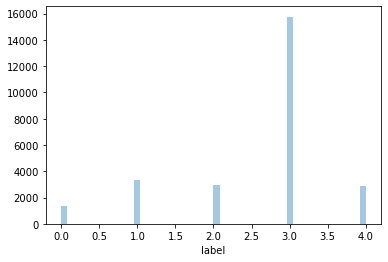

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = True
    print_freq = 100
    num_workers = 4
    model_name = "tf_efficientnet_b4_ns"  # resnext50_32x4d, seresnext50_32x4d, tf_efficientnet_b3_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 16
    gradient_accumulation_steps = 2
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.2
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    )  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 4345
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         279
      1         671
      2         590
      3        3153
      4         575
1     0         278
      1         671
      2         590
      3        3154
      4         575
2     0         278
      1         672
      2         589
      3        3153
      4         575
3     0         278
      1         672
      2         589
      3        3153
      4         575
4     0         278
      1         672
      2         589
      3        3153
      4         575
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df[[0, 1, 2, 3, 4]].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).float()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

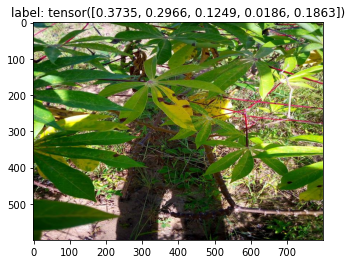

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                CenterCrop(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

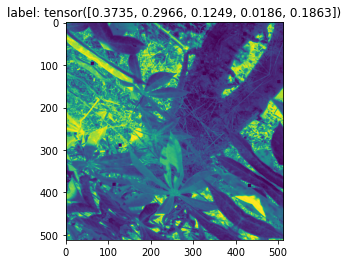

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, y_b, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if "resnext50_32x4d" in model_name:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    if CFG.model_name.startswith("vit_"):
        try:
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                    m.eval()
        except ValuError:
            print("error with batchnorm2d or layernorm")
            return

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
# print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[-0.1136, -0.0275, -0.0638, -0.0219,  0.0110],
        [-0.0199,  0.0141, -0.1306, -0.1365,  0.0059],
        [-0.0290,  0.0125, -0.1253, -0.1239,  0.0049],
        [-0.4218, -0.4824,  0.2077,  0.5835, -0.0065]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.shape[0]

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, labels, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.shape[0]
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [23]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/1316] Elapsed 0m 2s (remain 49m 41s) Loss: 0.2054(0.2054) Grad: 0.2171 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 34s (remain 6m 59s) Loss: 0.0640(0.1118) Grad: 0.1675 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 7s (remain 6m 13s) Loss: 0.0119(0.0833) Grad: 0.0676 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 39s (remain 5m 36s) Loss: 0.0408(0.0698) Grad: 0.1943 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 12s (remain 5m 1s) Loss: 0.0243(0.0609) Grad: 0.1583 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 44s (remain 4m 27s) Loss: 0.0275(0.0542) Grad: 0.1963 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 17s (remain 3m 54s) Loss: 0.0142(0.0492) Grad: 0.1175 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 49s (remain 3m 21s) Loss: 0.0315(0.0464) Grad: 0.1504 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 21s (remain 2m 48s) Loss: 0.0094(0.0434) Grad: 0.1011 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 54s (remain 2m 15s) Loss: 0.0161(0.0409) Grad: 0.1259 LR: 0.000

Epoch 1 - avg_train_loss: 0.0335  avg_val_loss: 0.0115  time: 485s
Epoch 1 - Accuracy: 0.9341305998481397
Epoch 1 - Save Best Score: 0.9341 Model


EVAL: [329/330] Elapsed 0m 57s (remain 0m 0s) Loss: 0.0114(0.0115) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 23m 7s) Loss: 0.0090(0.0090) Grad: 0.0749 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 32s (remain 6m 30s) Loss: 0.0119(0.0114) Grad: 0.1228 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 3s (remain 5m 53s) Loss: 0.0174(0.0115) Grad: 0.1300 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 34s (remain 5m 19s) Loss: 0.0210(0.0111) Grad: 0.1525 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 6s (remain 4m 47s) Loss: 0.0060(0.0108) Grad: 0.0593 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 37s (remain 4m 16s) Loss: 0.0081(0.0106) Grad: 0.1186 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 8s (remain 3m 44s) Loss: 0.0067(0.0105) Grad: 0.0867 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 39s (remain 3m 12s) Loss: 0.0044(0.0104) Grad: 0.0522 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 11s (remain 2m 41s) Loss: 0.0060(0.0102) Grad: 0.0715 LR: 0.000094  
Epoch: [2][900/1316] Elapsed 

Epoch 2 - avg_train_loss: 0.0097  avg_val_loss: 0.0091  time: 449s
Epoch 2 - Accuracy: 0.9369779802581625
Epoch 2 - Save Best Score: 0.9370 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0178(0.0091) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 27m 38s) Loss: 0.1012(0.1012) Grad: 0.1294 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 33s (remain 6m 47s) Loss: 0.0775(0.0676) Grad: 0.1374 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 6s (remain 6m 9s) Loss: 0.0692(0.0654) Grad: 0.1111 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 39s (remain 5m 35s) Loss: 0.0717(0.0636) Grad: 0.1120 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 12s (remain 5m 1s) Loss: 0.0595(0.0638) Grad: 0.0951 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 44s (remain 4m 27s) Loss: 0.0856(0.0645) Grad: 0.1327 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 17s (remain 3m 54s) Loss: 0.0175(0.0637) Grad: 0.1211 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 50s (remain 3m 22s) Loss: 0.0805(0.0632) Grad: 0.1769 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 23s (remain 2m 49s) Loss: 0.0713(0.0622) Grad: 0.1335 LR: 0.000084  
Epoch: [3][900/1316] Elapsed

Epoch 3 - avg_train_loss: 0.0613  avg_val_loss: 0.0122  time: 471s
Epoch 3 - Accuracy: 0.9328018223234624


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0187(0.0122) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 27m 51s) Loss: 0.0180(0.0180) Grad: 0.1115 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 34s (remain 6m 59s) Loss: 0.0496(0.0593) Grad: 0.1463 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 8s (remain 6m 19s) Loss: 0.0717(0.0569) Grad: 0.0977 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 41s (remain 5m 41s) Loss: 0.0290(0.0573) Grad: 0.0595 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 14s (remain 5m 6s) Loss: 0.0427(0.0569) Grad: 0.0951 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 47s (remain 4m 32s) Loss: 0.1028(0.0580) Grad: 0.0997 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 20s (remain 3m 58s) Loss: 0.0373(0.0570) Grad: 0.1010 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 3m 53s (remain 3m 24s) Loss: 0.0596(0.0572) Grad: 0.1550 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 26s (remain 2m 51s) Loss: 0.0225(0.0568) Grad: 0.1371 LR: 0.000072  
Epoch: [4][900/1316] Elapse

Epoch 4 - avg_train_loss: 0.0576  avg_val_loss: 0.0103  time: 472s
Epoch 4 - Accuracy: 0.935459377372817


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0490(0.0103) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 28m 29s) Loss: 0.0554(0.0554) Grad: 0.1323 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 34s (remain 6m 50s) Loss: 0.0432(0.0530) Grad: 0.1516 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 7s (remain 6m 14s) Loss: 0.0100(0.0542) Grad: 0.0827 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 40s (remain 5m 40s) Loss: 0.0871(0.0548) Grad: 0.0808 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 14s (remain 5m 6s) Loss: 0.0260(0.0550) Grad: 0.1199 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 48s (remain 4m 33s) Loss: 0.0964(0.0537) Grad: 0.1030 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 21s (remain 3m 59s) Loss: 0.0346(0.0534) Grad: 0.1157 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 3m 54s (remain 3m 26s) Loss: 0.0736(0.0533) Grad: 0.0840 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 28s (remain 2m 52s) Loss: 0.0225(0.0528) Grad: 0.1039 LR: 0.000057  
Epoch: [5][900/1316] Elapse

Epoch 5 - avg_train_loss: 0.0533  avg_val_loss: 0.0088  time: 476s
Epoch 5 - Accuracy: 0.940584662110858
Epoch 5 - Save Best Score: 0.9406 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0285(0.0088) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 31m 44s) Loss: 0.0455(0.0455) Grad: 0.0429 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 34s (remain 6m 50s) Loss: 0.0830(0.0464) Grad: 0.1042 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 6s (remain 6m 9s) Loss: 0.0110(0.0458) Grad: 0.1113 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 38s (remain 5m 33s) Loss: 0.0211(0.0480) Grad: 0.1383 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 11s (remain 5m 0s) Loss: 0.0667(0.0490) Grad: 0.1240 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 43s (remain 4m 26s) Loss: 0.0347(0.0508) Grad: 0.0799 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 16s (remain 3m 53s) Loss: 0.0084(0.0511) Grad: 0.0561 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 3m 48s (remain 3m 20s) Loss: 0.1267(0.0514) Grad: 0.1319 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 20s (remain 2m 47s) Loss: 0.0845(0.0519) Grad: 0.1021 LR: 0.000042  
Epoch: [6][900/1316] Elapsed

Epoch 6 - avg_train_loss: 0.0529  avg_val_loss: 0.0099  time: 464s
Epoch 6 - Accuracy: 0.9390660592255126


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0450(0.0099) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 27m 5s) Loss: 0.0981(0.0981) Grad: 0.1207 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 33s (remain 6m 42s) Loss: 0.0338(0.0350) Grad: 0.0833 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 5s (remain 6m 1s) Loss: 0.0068(0.0335) Grad: 0.0726 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 36s (remain 5m 26s) Loss: 0.0286(0.0341) Grad: 0.1516 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 8s (remain 4m 54s) Loss: 0.0835(0.0334) Grad: 0.1282 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 41s (remain 4m 21s) Loss: 0.0172(0.0343) Grad: 0.1283 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 12s (remain 3m 49s) Loss: 0.0069(0.0341) Grad: 0.0747 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 44s (remain 3m 17s) Loss: 0.0346(0.0338) Grad: 0.1860 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 16s (remain 2m 44s) Loss: 0.0234(0.0334) Grad: 0.1266 LR: 0.000027  
Epoch: [7][900/1316] Elapsed 

Epoch 7 - avg_train_loss: 0.0329  avg_val_loss: 0.0069  time: 458s
Epoch 7 - Accuracy: 0.9438116932422171
Epoch 7 - Save Best Score: 0.9438 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0401(0.0069) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 30m 7s) Loss: 0.0826(0.0826) Grad: 0.1297 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 34s (remain 6m 53s) Loss: 0.0878(0.0332) Grad: 0.0647 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 7s (remain 6m 17s) Loss: 0.0102(0.0346) Grad: 0.0967 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 40s (remain 5m 38s) Loss: 0.0084(0.0330) Grad: 0.0745 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 13s (remain 5m 3s) Loss: 0.0083(0.0320) Grad: 0.0953 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 45s (remain 4m 29s) Loss: 0.0115(0.0331) Grad: 0.0881 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 18s (remain 3m 55s) Loss: 0.0110(0.0319) Grad: 0.0762 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 50s (remain 3m 22s) Loss: 0.0368(0.0322) Grad: 0.0593 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 22s (remain 2m 48s) Loss: 0.0184(0.0319) Grad: 0.1202 LR: 0.000015  
Epoch: [8][900/1316] Elapsed

Epoch 8 - avg_train_loss: 0.0310  avg_val_loss: 0.0069  time: 467s
Epoch 8 - Accuracy: 0.9409643128321944


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0493(0.0069) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 28m 6s) Loss: 0.0701(0.0701) Grad: 0.0700 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 34s (remain 6m 49s) Loss: 0.0036(0.0278) Grad: 0.0497 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 6s (remain 6m 10s) Loss: 0.0529(0.0310) Grad: 0.1108 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 39s (remain 5m 35s) Loss: 0.0524(0.0317) Grad: 0.0964 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 12s (remain 5m 1s) Loss: 0.0101(0.0326) Grad: 0.1121 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 44s (remain 4m 27s) Loss: 0.0104(0.0321) Grad: 0.0954 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 16s (remain 3m 54s) Loss: 0.0156(0.0324) Grad: 0.1291 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 3m 49s (remain 3m 21s) Loss: 0.0047(0.0323) Grad: 0.0826 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 21s (remain 2m 48s) Loss: 0.0559(0.0317) Grad: 0.0698 LR: 0.000007  
Epoch: [9][900/1316] Elapsed

Epoch 9 - avg_train_loss: 0.0317  avg_val_loss: 0.0067  time: 469s
Epoch 9 - Accuracy: 0.940584662110858


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0441(0.0067) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 25m 22s) Loss: 0.0051(0.0051) Grad: 0.0482 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 32s (remain 6m 35s) Loss: 0.0069(0.0058) Grad: 0.0753 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 4s (remain 5m 56s) Loss: 0.0049(0.0056) Grad: 0.0448 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 35s (remain 5m 21s) Loss: 0.0058(0.0056) Grad: 0.0731 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 6s (remain 4m 49s) Loss: 0.0024(0.0054) Grad: 0.0411 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 38s (remain 4m 17s) Loss: 0.0084(0.0053) Grad: 0.0939 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 9s (remain 3m 45s) Loss: 0.0131(0.0055) Grad: 0.0977 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 41s (remain 3m 13s) Loss: 0.0116(0.0054) Grad: 0.0979 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 12s (remain 2m 42s) Loss: 0.0020(0.0054) Grad: 0.0372 LR: 0.000002  
Epoch: [10][900/131

Epoch 10 - avg_train_loss: 0.0052  avg_val_loss: 0.0065  time: 452s
Epoch 10 - Accuracy: 0.9430523917995444
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0372(0.0065) 


========== fold: 0 result ==========
Score: 0.94381
========== fold: 1 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 25m 45s) Loss: 0.1888(0.1888) Grad: 0.2332 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 34s (remain 6m 52s) Loss: 0.0924(0.1094) Grad: 0.2329 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 7s (remain 6m 16s) Loss: 0.0401(0.0843) Grad: 0.1929 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 40s (remain 5m 40s) Loss: 0.0465(0.0699) Grad: 0.1746 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 14s (remain 5m 6s) Loss: 0.0155(0.0612) Grad: 0.1369 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 47s (remain 4m 32s) Loss: 0.0235(0.0549) Grad: 0.1051 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 20s (remain 3m 58s) Loss: 0.0100(0.0504) Grad: 0.0898 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 54s (remain 3m 25s) Loss: 0.0266(0.0466) Grad: 0.1948 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 27s (remain 2m 51s) Loss: 0.0093(0.0436) Grad: 0.0909 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 5m 0s (remain 2m 18s) Loss: 0.0287(0.0412) Grad: 0.1518 LR: 0.0000

Epoch 1 - avg_train_loss: 0.0342  avg_val_loss: 0.0121  time: 478s
Epoch 1 - Accuracy: 0.9339407744874715
Epoch 1 - Save Best Score: 0.9339 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0633(0.0121) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 24m 57s) Loss: 0.0058(0.0058) Grad: 0.0513 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 34s (remain 6m 58s) Loss: 0.0072(0.0126) Grad: 0.0651 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 7s (remain 6m 17s) Loss: 0.0071(0.0120) Grad: 0.0933 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 41s (remain 5m 40s) Loss: 0.0042(0.0119) Grad: 0.0605 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 14s (remain 5m 6s) Loss: 0.0127(0.0115) Grad: 0.1267 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 47s (remain 4m 32s) Loss: 0.0050(0.0112) Grad: 0.0473 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 20s (remain 3m 58s) Loss: 0.0035(0.0109) Grad: 0.0453 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 52s (remain 3m 24s) Loss: 0.0073(0.0106) Grad: 0.0698 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 25s (remain 2m 50s) Loss: 0.0059(0.0105) Grad: 0.0742 LR: 0.000094  
Epoch: [2][900/1316] Elapse

Epoch 2 - avg_train_loss: 0.0098  avg_val_loss: 0.0086  time: 466s
Epoch 2 - Accuracy: 0.9417236142748672
Epoch 2 - Save Best Score: 0.9417 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0314(0.0086) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 27m 18s) Loss: 0.0655(0.0655) Grad: 0.2003 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 34s (remain 7m 0s) Loss: 0.0526(0.0638) Grad: 0.2107 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 8s (remain 6m 18s) Loss: 0.0535(0.0622) Grad: 0.1069 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 41s (remain 5m 42s) Loss: 0.0627(0.0615) Grad: 0.1488 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 15s (remain 5m 9s) Loss: 0.1145(0.0608) Grad: 0.1454 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 49s (remain 4m 35s) Loss: 0.0112(0.0619) Grad: 0.0811 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 22s (remain 4m 1s) Loss: 0.1431(0.0633) Grad: 0.2596 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 56s (remain 3m 27s) Loss: 0.0348(0.0640) Grad: 0.1915 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 30s (remain 2m 53s) Loss: 0.0916(0.0629) Grad: 0.1143 LR: 0.000084  
Epoch: [3][900/1316] Elapsed 

Epoch 3 - avg_train_loss: 0.0606  avg_val_loss: 0.0108  time: 485s
Epoch 3 - Accuracy: 0.9407744874715261


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0346(0.0108) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 28m 40s) Loss: 0.0361(0.0361) Grad: 0.0636 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 36s (remain 7m 22s) Loss: 0.0648(0.0535) Grad: 0.1542 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 12s (remain 6m 42s) Loss: 0.0263(0.0559) Grad: 0.1490 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 48s (remain 6m 4s) Loss: 0.0147(0.0577) Grad: 0.1159 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 23s (remain 5m 27s) Loss: 0.0840(0.0569) Grad: 0.1344 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 59s (remain 4m 52s) Loss: 0.0130(0.0559) Grad: 0.1060 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 35s (remain 4m 16s) Loss: 0.0844(0.0568) Grad: 0.1262 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 4m 11s (remain 3m 40s) Loss: 0.0230(0.0568) Grad: 0.1014 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 47s (remain 3m 4s) Loss: 0.0880(0.0564) Grad: 0.0770 LR: 0.000072  
Epoch: [4][900/1316] Elapse

Epoch 4 - avg_train_loss: 0.0558  avg_val_loss: 0.0100  time: 505s
Epoch 4 - Accuracy: 0.9403948367501899


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0169(0.0100) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 29m 41s) Loss: 0.1224(0.1224) Grad: 0.1247 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 35s (remain 7m 7s) Loss: 0.0923(0.0566) Grad: 0.1363 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 10s (remain 6m 29s) Loss: 0.0295(0.0568) Grad: 0.0894 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 45s (remain 5m 54s) Loss: 0.1008(0.0545) Grad: 0.1330 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 20s (remain 5m 19s) Loss: 0.0652(0.0542) Grad: 0.1231 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 54s (remain 4m 44s) Loss: 0.0938(0.0536) Grad: 0.1234 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 29s (remain 4m 9s) Loss: 0.0177(0.0534) Grad: 0.0474 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 4m 4s (remain 3m 34s) Loss: 0.0656(0.0534) Grad: 0.0860 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 38s (remain 2m 59s) Loss: 0.0424(0.0542) Grad: 0.0977 LR: 0.000057  
Epoch: [5][900/1316] Elapsed

Epoch 5 - avg_train_loss: 0.0538  avg_val_loss: 0.0091  time: 498s
Epoch 5 - Accuracy: 0.9424829157175398
Epoch 5 - Save Best Score: 0.9425 Model


EVAL: [329/330] Elapsed 0m 40s (remain 0m 0s) Loss: 0.0230(0.0091) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 27m 42s) Loss: 0.1170(0.1170) Grad: 0.1241 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 37s (remain 7m 29s) Loss: 0.0166(0.0518) Grad: 0.0724 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 13s (remain 6m 46s) Loss: 0.0237(0.0531) Grad: 0.1797 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 49s (remain 6m 8s) Loss: 0.0675(0.0529) Grad: 0.0788 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 23s (remain 5m 28s) Loss: 0.1261(0.0530) Grad: 0.1070 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 59s (remain 4m 51s) Loss: 0.0484(0.0532) Grad: 0.0971 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 34s (remain 4m 15s) Loss: 0.0178(0.0522) Grad: 0.1305 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 4m 10s (remain 3m 40s) Loss: 0.0396(0.0516) Grad: 0.1008 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 46s (remain 3m 4s) Loss: 0.0247(0.0514) Grad: 0.1355 LR: 0.000042  
Epoch: [6][900/1316] Elapse

Epoch 6 - avg_train_loss: 0.0522  avg_val_loss: 0.0089  time: 511s
Epoch 6 - Accuracy: 0.9422930903568717


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0195(0.0089) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 31m 17s) Loss: 0.0294(0.0294) Grad: 0.0378 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 36s (remain 7m 18s) Loss: 0.0189(0.0340) Grad: 0.0688 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 11s (remain 6m 33s) Loss: 0.0839(0.0332) Grad: 0.1647 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 46s (remain 5m 58s) Loss: 0.0790(0.0331) Grad: 0.1016 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 20s (remain 5m 21s) Loss: 0.0113(0.0343) Grad: 0.0863 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 55s (remain 4m 46s) Loss: 0.0986(0.0339) Grad: 0.0960 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 30s (remain 4m 10s) Loss: 0.0125(0.0336) Grad: 0.0880 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 4m 4s (remain 3m 34s) Loss: 0.0134(0.0336) Grad: 0.1010 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 39s (remain 2m 59s) Loss: 0.0364(0.0323) Grad: 0.1252 LR: 0.000027  
Epoch: [7][900/1316] Elaps

Epoch 7 - avg_train_loss: 0.0325  avg_val_loss: 0.0086  time: 496s
Epoch 7 - Accuracy: 0.9409643128321944


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0319(0.0086) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 32m 3s) Loss: 0.0881(0.0881) Grad: 0.0945 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 36s (remain 7m 17s) Loss: 0.0728(0.0365) Grad: 0.0928 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 10s (remain 6m 31s) Loss: 0.0054(0.0339) Grad: 0.0285 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 44s (remain 5m 53s) Loss: 0.0044(0.0329) Grad: 0.0479 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 18s (remain 5m 17s) Loss: 0.0026(0.0340) Grad: 0.0357 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 53s (remain 4m 43s) Loss: 0.0565(0.0341) Grad: 0.0934 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 28s (remain 4m 8s) Loss: 0.1064(0.0333) Grad: 0.0705 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 4m 3s (remain 3m 33s) Loss: 0.0065(0.0335) Grad: 0.0648 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 38s (remain 2m 58s) Loss: 0.0085(0.0330) Grad: 0.0686 LR: 0.000015  
Epoch: [8][900/1316] Elapsed

Epoch 8 - avg_train_loss: 0.0323  avg_val_loss: 0.0079  time: 496s
Epoch 8 - Accuracy: 0.9421032649962034


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0168(0.0079) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 28m 18s) Loss: 0.0117(0.0117) Grad: 0.1390 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 36s (remain 7m 20s) Loss: 0.0052(0.0288) Grad: 0.0672 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 11s (remain 6m 36s) Loss: 0.1034(0.0298) Grad: 0.0762 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 46s (remain 5m 58s) Loss: 0.0101(0.0303) Grad: 0.0817 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 21s (remain 5m 22s) Loss: 0.0837(0.0317) Grad: 0.1006 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 56s (remain 4m 47s) Loss: 0.0334(0.0312) Grad: 0.1634 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 31s (remain 4m 11s) Loss: 0.0097(0.0315) Grad: 0.0904 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 4m 5s (remain 3m 35s) Loss: 0.0774(0.0312) Grad: 0.0852 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 40s (remain 3m 0s) Loss: 0.0066(0.0307) Grad: 0.0493 LR: 0.000007  
Epoch: [9][900/1316] Elapse

Epoch 9 - avg_train_loss: 0.0300  avg_val_loss: 0.0068  time: 496s
Epoch 9 - Accuracy: 0.9447608200455581
Epoch 9 - Save Best Score: 0.9448 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0160(0.0068) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 26m 23s) Loss: 0.0053(0.0053) Grad: 0.0852 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 34s (remain 6m 54s) Loss: 0.0013(0.0063) Grad: 0.0227 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 7s (remain 6m 14s) Loss: 0.0023(0.0061) Grad: 0.0271 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 40s (remain 5m 38s) Loss: 0.0043(0.0059) Grad: 0.0437 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 13s (remain 5m 4s) Loss: 0.0062(0.0058) Grad: 0.0542 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 46s (remain 4m 30s) Loss: 0.0070(0.0057) Grad: 0.0759 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 18s (remain 3m 56s) Loss: 0.0013(0.0055) Grad: 0.0245 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 51s (remain 3m 23s) Loss: 0.0025(0.0055) Grad: 0.0369 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 24s (remain 2m 50s) Loss: 0.0025(0.0054) Grad: 0.0333 LR: 0.000002  
Epoch: [10][900/13

Epoch 10 - avg_train_loss: 0.0053  avg_val_loss: 0.0060  time: 471s
Epoch 10 - Accuracy: 0.9472285497342445
Epoch 10 - Save Best Score: 0.9472 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0301(0.0060) 


Epoch 10 - Save final model
========== fold: 1 result ==========
Score: 0.94723
========== fold: 2 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 25m 12s) Loss: 0.2116(0.2116) Grad: 0.2437 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 36s (remain 7m 13s) Loss: 0.1055(0.1121) Grad: 0.2475 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 10s (remain 6m 32s) Loss: 0.0604(0.0878) Grad: 0.2206 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 45s (remain 5m 55s) Loss: 0.0240(0.0728) Grad: 0.1569 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 19s (remain 5m 18s) Loss: 0.0112(0.0626) Grad: 0.0855 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 54s (remain 4m 43s) Loss: 0.0383(0.0565) Grad: 0.2010 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 28s (remain 4m 8s) Loss: 0.0421(0.0516) Grad: 0.1718 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 4m 3s (remain 3m 33s) Loss: 0.0278(0.0477) Grad: 0.1721 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 38s (remain 2m 58s) Loss: 0.0182(0.0449) Grad: 0.1505 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 5m 13s (remain 2m 24s) Loss: 0.0365(0.0424) Grad: 0.1667 LR: 0.000

Epoch 1 - avg_train_loss: 0.0349  avg_val_loss: 0.0106  time: 493s
Epoch 1 - Accuracy: 0.9352572621985951
Epoch 1 - Save Best Score: 0.9353 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0035(0.0106) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 24m 39s) Loss: 0.0146(0.0146) Grad: 0.1096 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 35s (remain 7m 3s) Loss: 0.0215(0.0116) Grad: 0.1548 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 9s (remain 6m 23s) Loss: 0.0078(0.0116) Grad: 0.0830 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 42s (remain 5m 44s) Loss: 0.0273(0.0109) Grad: 0.1490 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 15s (remain 5m 8s) Loss: 0.0115(0.0107) Grad: 0.1077 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 48s (remain 4m 34s) Loss: 0.0097(0.0106) Grad: 0.0869 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 22s (remain 4m 0s) Loss: 0.0041(0.0107) Grad: 0.0650 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 57s (remain 3m 28s) Loss: 0.0041(0.0105) Grad: 0.0456 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 33s (remain 2m 55s) Loss: 0.0081(0.0105) Grad: 0.1115 LR: 0.000094  
Epoch: [2][900/1316] Elapsed 

Epoch 2 - avg_train_loss: 0.0098  avg_val_loss: 0.0083  time: 497s
Epoch 2 - Accuracy: 0.9470286690715778
Epoch 2 - Save Best Score: 0.9470 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0007(0.0083) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 26m 44s) Loss: 0.0907(0.0907) Grad: 0.1627 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 38s (remain 7m 42s) Loss: 0.1319(0.0655) Grad: 0.1638 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 15s (remain 7m 0s) Loss: 0.0399(0.0675) Grad: 0.1824 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 53s (remain 6m 21s) Loss: 0.0429(0.0684) Grad: 0.1662 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 30s (remain 5m 43s) Loss: 0.0788(0.0665) Grad: 0.0771 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 3m 8s (remain 5m 7s) Loss: 0.0176(0.0658) Grad: 0.1556 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 46s (remain 4m 29s) Loss: 0.0916(0.0654) Grad: 0.1097 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 4m 25s (remain 3m 52s) Loss: 0.0484(0.0645) Grad: 0.2052 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 5m 3s (remain 3m 15s) Loss: 0.0429(0.0640) Grad: 0.1311 LR: 0.000084  
Epoch: [3][900/1316] Elapsed 

Epoch 3 - avg_train_loss: 0.0632  avg_val_loss: 0.0096  time: 536s
Epoch 3 - Accuracy: 0.9470286690715778


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0037(0.0096) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 29m 37s) Loss: 0.0601(0.0601) Grad: 0.0876 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 38s (remain 7m 46s) Loss: 0.0205(0.0584) Grad: 0.0582 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 16s (remain 7m 2s) Loss: 0.0384(0.0551) Grad: 0.1188 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 53s (remain 6m 22s) Loss: 0.0855(0.0547) Grad: 0.0975 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 30s (remain 5m 44s) Loss: 0.0192(0.0555) Grad: 0.1307 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 3m 7s (remain 5m 5s) Loss: 0.0839(0.0543) Grad: 0.0892 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 44s (remain 4m 26s) Loss: 0.0733(0.0545) Grad: 0.1273 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 4m 21s (remain 3m 49s) Loss: 0.0186(0.0551) Grad: 0.1232 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 58s (remain 3m 11s) Loss: 0.0262(0.0555) Grad: 0.1563 LR: 0.000072  
Epoch: [4][900/1316] Elapsed

Epoch 4 - avg_train_loss: 0.0562  avg_val_loss: 0.0095  time: 527s
Epoch 4 - Accuracy: 0.9479779760774635
Epoch 4 - Save Best Score: 0.9480 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0008(0.0095) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 30m 31s) Loss: 0.0760(0.0760) Grad: 0.1188 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 38s (remain 7m 40s) Loss: 0.1045(0.0561) Grad: 0.1117 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 15s (remain 6m 57s) Loss: 0.0718(0.0552) Grad: 0.1045 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 51s (remain 6m 17s) Loss: 0.1251(0.0538) Grad: 0.1249 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 28s (remain 5m 39s) Loss: 0.0311(0.0538) Grad: 0.1274 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 3m 5s (remain 5m 1s) Loss: 0.0351(0.0540) Grad: 0.0800 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 41s (remain 4m 23s) Loss: 0.0792(0.0537) Grad: 0.0659 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 4m 18s (remain 3m 46s) Loss: 0.0046(0.0534) Grad: 0.0379 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 55s (remain 3m 9s) Loss: 0.0825(0.0529) Grad: 0.1254 LR: 0.000057  
Epoch: [5][900/1316] Elapsed

Epoch 5 - avg_train_loss: 0.0528  avg_val_loss: 0.0104  time: 524s
Epoch 5 - Accuracy: 0.9443706094550978


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0043(0.0104) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 29m 20s) Loss: 0.0061(0.0061) Grad: 0.0577 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 38s (remain 7m 46s) Loss: 0.0146(0.0550) Grad: 0.1135 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 15s (remain 6m 58s) Loss: 0.0082(0.0535) Grad: 0.0763 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 52s (remain 6m 20s) Loss: 0.0646(0.0541) Grad: 0.1095 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 29s (remain 5m 41s) Loss: 0.0714(0.0519) Grad: 0.0560 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 3m 6s (remain 5m 3s) Loss: 0.0139(0.0522) Grad: 0.0441 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 43s (remain 4m 25s) Loss: 0.1020(0.0525) Grad: 0.0838 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 4m 20s (remain 3m 48s) Loss: 0.1087(0.0523) Grad: 0.1287 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 57s (remain 3m 11s) Loss: 0.0847(0.0528) Grad: 0.0910 LR: 0.000042  
Epoch: [6][900/1316] Elapse

Epoch 6 - avg_train_loss: 0.0523  avg_val_loss: 0.0077  time: 524s
Epoch 6 - Accuracy: 0.9479779760774635


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0008(0.0077) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 30m 28s) Loss: 0.0073(0.0073) Grad: 0.0609 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 37s (remain 7m 27s) Loss: 0.0195(0.0340) Grad: 0.1006 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 12s (remain 6m 43s) Loss: 0.0080(0.0345) Grad: 0.0638 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 48s (remain 6m 4s) Loss: 0.0779(0.0342) Grad: 0.0908 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 23s (remain 5m 27s) Loss: 0.0097(0.0339) Grad: 0.0966 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 58s (remain 4m 50s) Loss: 0.0046(0.0344) Grad: 0.0610 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 34s (remain 4m 15s) Loss: 0.0821(0.0345) Grad: 0.0775 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 4m 10s (remain 3m 39s) Loss: 0.0140(0.0346) Grad: 0.0514 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 45s (remain 3m 3s) Loss: 0.0039(0.0347) Grad: 0.0546 LR: 0.000027  
Epoch: [7][900/1316] Elapse

Epoch 7 - avg_train_loss: 0.0325  avg_val_loss: 0.0066  time: 510s
Epoch 7 - Accuracy: 0.9489272830833492
Epoch 7 - Save Best Score: 0.9489 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0007(0.0066) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 28m 57s) Loss: 0.0093(0.0093) Grad: 0.0894 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 38s (remain 7m 48s) Loss: 0.0785(0.0344) Grad: 0.0692 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 14s (remain 6m 53s) Loss: 0.0040(0.0333) Grad: 0.0646 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 49s (remain 6m 10s) Loss: 0.0448(0.0314) Grad: 0.0737 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 25s (remain 5m 32s) Loss: 0.0424(0.0318) Grad: 0.1135 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 3m 1s (remain 4m 55s) Loss: 0.0566(0.0318) Grad: 0.0615 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 37s (remain 4m 19s) Loss: 0.0052(0.0324) Grad: 0.0911 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 4m 14s (remain 3m 43s) Loss: 0.0064(0.0325) Grad: 0.0666 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 50s (remain 3m 6s) Loss: 0.0212(0.0322) Grad: 0.1369 LR: 0.000015  
Epoch: [8][900/1316] Elapse

Epoch 8 - avg_train_loss: 0.0321  avg_val_loss: 0.0071  time: 514s
Epoch 8 - Accuracy: 0.9468388076704006


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0009(0.0071) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 29m 42s) Loss: 0.0050(0.0050) Grad: 0.0518 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 37s (remain 7m 27s) Loss: 0.0058(0.0335) Grad: 0.0652 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 12s (remain 6m 44s) Loss: 0.0198(0.0341) Grad: 0.1638 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 48s (remain 6m 6s) Loss: 0.0404(0.0332) Grad: 0.0826 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 25s (remain 5m 31s) Loss: 0.0691(0.0332) Grad: 0.0916 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 3m 1s (remain 4m 55s) Loss: 0.0042(0.0336) Grad: 0.0394 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 37s (remain 4m 18s) Loss: 0.0148(0.0331) Grad: 0.1190 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 4m 13s (remain 3m 42s) Loss: 0.0500(0.0336) Grad: 0.0652 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 48s (remain 3m 5s) Loss: 0.1210(0.0331) Grad: 0.2066 LR: 0.000007  
Epoch: [9][900/1316] Elapsed

Epoch 9 - avg_train_loss: 0.0331  avg_val_loss: 0.0069  time: 513s
Epoch 9 - Accuracy: 0.9477881146762863


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0009(0.0069) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 25m 13s) Loss: 0.0101(0.0101) Grad: 0.0950 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 36s (remain 7m 15s) Loss: 0.0068(0.0058) Grad: 0.0695 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 11s (remain 6m 33s) Loss: 0.0062(0.0057) Grad: 0.0849 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 45s (remain 5m 56s) Loss: 0.0065(0.0055) Grad: 0.1066 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 20s (remain 5m 20s) Loss: 0.0082(0.0054) Grad: 0.0860 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 55s (remain 4m 45s) Loss: 0.0024(0.0053) Grad: 0.0353 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 31s (remain 4m 11s) Loss: 0.0034(0.0053) Grad: 0.0570 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 4m 7s (remain 3m 37s) Loss: 0.0088(0.0053) Grad: 0.0904 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 44s (remain 3m 2s) Loss: 0.0010(0.0052) Grad: 0.0173 LR: 0.000002  
Epoch: [10][900/13

Epoch 10 - avg_train_loss: 0.0050  avg_val_loss: 0.0059  time: 512s
Epoch 10 - Accuracy: 0.950066451490412
Epoch 10 - Save Best Score: 0.9501 Model


EVAL: [329/330] Elapsed 0m 40s (remain 0m 0s) Loss: 0.0021(0.0059) 


Epoch 10 - Save final model
========== fold: 2 result ==========
Score: 0.95007
========== fold: 3 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 30m 0s) Loss: 0.2059(0.2059) Grad: 0.2524 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 39s (remain 7m 55s) Loss: 0.0858(0.1129) Grad: 0.1996 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 17s (remain 7m 12s) Loss: 0.1044(0.0879) Grad: 0.2380 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 56s (remain 6m 32s) Loss: 0.0519(0.0722) Grad: 0.2249 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 33s (remain 5m 51s) Loss: 0.0282(0.0628) Grad: 0.1386 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 3m 11s (remain 5m 11s) Loss: 0.0247(0.0557) Grad: 0.1928 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 49s (remain 4m 32s) Loss: 0.0213(0.0509) Grad: 0.1455 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 4m 27s (remain 3m 54s) Loss: 0.0292(0.0470) Grad: 0.2142 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 5m 5s (remain 3m 16s) Loss: 0.0087(0.0440) Grad: 0.0825 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 5m 43s (remain 2m 38s) Loss: 0.0099(0.0416) Grad: 0.0696 LR: 0.000

Epoch 1 - avg_train_loss: 0.0343  avg_val_loss: 0.0108  time: 543s
Epoch 1 - Accuracy: 0.9434213024492121
Epoch 1 - Save Best Score: 0.9434 Model


EVAL: [329/330] Elapsed 0m 41s (remain 0m 0s) Loss: 0.0033(0.0108) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 27m 57s) Loss: 0.0134(0.0134) Grad: 0.1008 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 39s (remain 7m 56s) Loss: 0.0055(0.0120) Grad: 0.0591 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 17s (remain 7m 8s) Loss: 0.0020(0.0112) Grad: 0.0282 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 54s (remain 6m 27s) Loss: 0.0086(0.0112) Grad: 0.0987 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 32s (remain 5m 48s) Loss: 0.0047(0.0110) Grad: 0.0554 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 3m 10s (remain 5m 9s) Loss: 0.0081(0.0108) Grad: 0.0961 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 47s (remain 4m 30s) Loss: 0.0158(0.0106) Grad: 0.1041 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 4m 25s (remain 3m 52s) Loss: 0.0042(0.0105) Grad: 0.0458 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 5m 3s (remain 3m 15s) Loss: 0.0074(0.0103) Grad: 0.0817 LR: 0.000094  
Epoch: [2][900/1316] Elapsed

Epoch 2 - avg_train_loss: 0.0096  avg_val_loss: 0.0083  time: 544s
Epoch 2 - Accuracy: 0.9456996392633378
Epoch 2 - Save Best Score: 0.9457 Model


EVAL: [329/330] Elapsed 0m 41s (remain 0m 0s) Loss: 0.0106(0.0083) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 33m 8s) Loss: 0.0577(0.0577) Grad: 0.2742 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 41s (remain 8m 19s) Loss: 0.0199(0.0710) Grad: 0.1377 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 21s (remain 7m 31s) Loss: 0.0382(0.0655) Grad: 0.1778 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 2m 1s (remain 6m 50s) Loss: 0.0251(0.0658) Grad: 0.1620 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 41s (remain 6m 9s) Loss: 0.0416(0.0638) Grad: 0.1328 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 3m 21s (remain 5m 28s) Loss: 0.0229(0.0627) Grad: 0.1331 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 4m 2s (remain 4m 48s) Loss: 0.0657(0.0634) Grad: 0.1017 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 4m 42s (remain 4m 8s) Loss: 0.0436(0.0627) Grad: 0.1431 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 5m 22s (remain 3m 27s) Loss: 0.0753(0.0618) Grad: 0.0874 LR: 0.000084  
Epoch: [3][900/1316] Elapsed 6

Epoch 3 - avg_train_loss: 0.0607  avg_val_loss: 0.0100  time: 571s
Epoch 3 - Accuracy: 0.9398139358268464


EVAL: [329/330] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0045(0.0100) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 32m 31s) Loss: 0.0953(0.0953) Grad: 0.1320 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 42s (remain 8m 28s) Loss: 0.0446(0.0535) Grad: 0.0968 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 22s (remain 7m 35s) Loss: 0.0702(0.0555) Grad: 0.1052 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 2m 1s (remain 6m 49s) Loss: 0.0234(0.0565) Grad: 0.1393 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 41s (remain 6m 7s) Loss: 0.0138(0.0567) Grad: 0.0827 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 3m 21s (remain 5m 28s) Loss: 0.0071(0.0559) Grad: 0.0662 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 4m 1s (remain 4m 47s) Loss: 0.0413(0.0567) Grad: 0.1066 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 4m 42s (remain 4m 7s) Loss: 0.1047(0.0564) Grad: 0.1065 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 5m 22s (remain 3m 27s) Loss: 0.0458(0.0556) Grad: 0.0879 LR: 0.000072  
Epoch: [4][900/1316] Elapsed 

Epoch 4 - avg_train_loss: 0.0556  avg_val_loss: 0.0083  time: 570s
Epoch 4 - Accuracy: 0.9436111638503892


EVAL: [329/330] Elapsed 0m 41s (remain 0m 0s) Loss: 0.0011(0.0083) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 31m 43s) Loss: 0.0218(0.0218) Grad: 0.1352 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 41s (remain 8m 15s) Loss: 0.0096(0.0530) Grad: 0.1006 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 20s (remain 7m 26s) Loss: 0.0181(0.0530) Grad: 0.0883 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 2m 0s (remain 6m 45s) Loss: 0.0239(0.0534) Grad: 0.0566 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 40s (remain 6m 5s) Loss: 0.0492(0.0521) Grad: 0.0690 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 3m 20s (remain 5m 25s) Loss: 0.0862(0.0527) Grad: 0.1253 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 4m 0s (remain 4m 45s) Loss: 0.0401(0.0521) Grad: 0.1202 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 4m 40s (remain 4m 5s) Loss: 0.1017(0.0523) Grad: 0.0910 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 5m 20s (remain 3m 25s) Loss: 0.0049(0.0523) Grad: 0.0484 LR: 0.000057  
Epoch: [5][900/1316] Elapsed 

Epoch 5 - avg_train_loss: 0.0517  avg_val_loss: 0.0092  time: 567s
Epoch 5 - Accuracy: 0.9496867286880577
Epoch 5 - Save Best Score: 0.9497 Model


EVAL: [329/330] Elapsed 0m 41s (remain 0m 0s) Loss: 0.0026(0.0092) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 33m 6s) Loss: 0.0255(0.0255) Grad: 0.0643 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 41s (remain 8m 14s) Loss: 0.0134(0.0505) Grad: 0.0944 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 20s (remain 7m 26s) Loss: 0.0088(0.0506) Grad: 0.0811 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 2m 0s (remain 6m 46s) Loss: 0.0824(0.0506) Grad: 0.0826 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 40s (remain 6m 6s) Loss: 0.0462(0.0517) Grad: 0.0571 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 3m 20s (remain 5m 25s) Loss: 0.0854(0.0511) Grad: 0.0898 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 4m 0s (remain 4m 46s) Loss: 0.0098(0.0515) Grad: 0.0705 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 4m 39s (remain 4m 5s) Loss: 0.0439(0.0513) Grad: 0.0818 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 5m 19s (remain 3m 25s) Loss: 0.0806(0.0514) Grad: 0.0853 LR: 0.000042  
Epoch: [6][900/1316] Elapsed 5

Epoch 6 - avg_train_loss: 0.0520  avg_val_loss: 0.0082  time: 563s
Epoch 6 - Accuracy: 0.9525346497057148
Epoch 6 - Save Best Score: 0.9525 Model


EVAL: [329/330] Elapsed 0m 40s (remain 0m 0s) Loss: 0.0022(0.0082) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 30m 42s) Loss: 0.0089(0.0089) Grad: 0.0645 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 40s (remain 8m 5s) Loss: 0.0827(0.0326) Grad: 0.0858 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 18s (remain 7m 16s) Loss: 0.0188(0.0315) Grad: 0.1613 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 57s (remain 6m 35s) Loss: 0.0093(0.0312) Grad: 0.0911 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 35s (remain 5m 54s) Loss: 0.0104(0.0310) Grad: 0.1132 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 3m 13s (remain 5m 14s) Loss: 0.0158(0.0311) Grad: 0.1781 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 52s (remain 4m 36s) Loss: 0.0159(0.0311) Grad: 0.1137 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 4m 30s (remain 3m 57s) Loss: 0.0047(0.0307) Grad: 0.0615 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 5m 8s (remain 3m 18s) Loss: 0.0079(0.0304) Grad: 0.0791 LR: 0.000027  
Epoch: [7][900/1316] Elapse

Epoch 7 - avg_train_loss: 0.0311  avg_val_loss: 0.0064  time: 546s
Epoch 7 - Accuracy: 0.9559521549269033
Epoch 7 - Save Best Score: 0.9560 Model


EVAL: [329/330] Elapsed 0m 40s (remain 0m 0s) Loss: 0.0045(0.0064) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 32m 30s) Loss: 0.0706(0.0706) Grad: 0.1021 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 39s (remain 7m 57s) Loss: 0.0109(0.0336) Grad: 0.1437 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 17s (remain 7m 12s) Loss: 0.0184(0.0305) Grad: 0.0592 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 56s (remain 6m 31s) Loss: 0.0434(0.0305) Grad: 0.0576 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 34s (remain 5m 53s) Loss: 0.1032(0.0327) Grad: 0.1064 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 3m 13s (remain 5m 14s) Loss: 0.0130(0.0316) Grad: 0.1189 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 51s (remain 4m 35s) Loss: 0.1021(0.0318) Grad: 0.0987 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 4m 30s (remain 3m 56s) Loss: 0.0102(0.0314) Grad: 0.0789 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 5m 8s (remain 3m 18s) Loss: 0.0038(0.0314) Grad: 0.0715 LR: 0.000015  
Epoch: [8][900/1316] Elaps

Epoch 8 - avg_train_loss: 0.0304  avg_val_loss: 0.0060  time: 546s
Epoch 8 - Accuracy: 0.9546231251186634


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0014(0.0060) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 31m 2s) Loss: 0.0063(0.0063) Grad: 0.0719 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 39s (remain 7m 53s) Loss: 0.0206(0.0269) Grad: 0.1206 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 17s (remain 7m 10s) Loss: 0.0775(0.0295) Grad: 0.1028 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 55s (remain 6m 29s) Loss: 0.0890(0.0313) Grad: 0.0612 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 33s (remain 5m 49s) Loss: 0.0088(0.0306) Grad: 0.0985 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 3m 11s (remain 5m 11s) Loss: 0.0402(0.0311) Grad: 0.1325 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 48s (remain 4m 32s) Loss: 0.0749(0.0304) Grad: 0.0981 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 4m 26s (remain 3m 53s) Loss: 0.0082(0.0306) Grad: 0.0792 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 5m 3s (remain 3m 15s) Loss: 0.0080(0.0299) Grad: 0.0778 LR: 0.000007  
Epoch: [9][900/1316] Elapse

Epoch 9 - avg_train_loss: 0.0302  avg_val_loss: 0.0065  time: 543s
Epoch 9 - Accuracy: 0.9555724321245491


EVAL: [329/330] Elapsed 0m 41s (remain 0m 0s) Loss: 0.0017(0.0065) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 26m 5s) Loss: 0.0179(0.0179) Grad: 0.1262 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 39s (remain 7m 50s) Loss: 0.0048(0.0064) Grad: 0.0567 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 16s (remain 7m 6s) Loss: 0.0024(0.0058) Grad: 0.0312 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 54s (remain 6m 26s) Loss: 0.0035(0.0058) Grad: 0.0463 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 31s (remain 5m 46s) Loss: 0.0058(0.0057) Grad: 0.0621 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 3m 8s (remain 5m 7s) Loss: 0.0041(0.0056) Grad: 0.0341 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 45s (remain 4m 28s) Loss: 0.0040(0.0054) Grad: 0.0428 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 4m 23s (remain 3m 50s) Loss: 0.0028(0.0052) Grad: 0.0453 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 5m 0s (remain 3m 12s) Loss: 0.0081(0.0052) Grad: 0.0596 LR: 0.000002  
Epoch: [10][900/1316]

Epoch 10 - avg_train_loss: 0.0051  avg_val_loss: 0.0057  time: 533s
Epoch 10 - Accuracy: 0.954053540915132
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 40s (remain 0m 0s) Loss: 0.0021(0.0057) 


========== fold: 3 result ==========
Score: 0.95595
========== fold: 4 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 27m 35s) Loss: 0.1986(0.1986) Grad: 0.2262 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 40s (remain 8m 10s) Loss: 0.0722(0.1157) Grad: 0.1704 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 20s (remain 7m 28s) Loss: 0.0460(0.0874) Grad: 0.2023 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 2m 1s (remain 6m 49s) Loss: 0.0365(0.0738) Grad: 0.2040 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 42s (remain 6m 11s) Loss: 0.0252(0.0638) Grad: 0.1754 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 3m 24s (remain 5m 32s) Loss: 0.0269(0.0575) Grad: 0.1624 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 4m 5s (remain 4m 51s) Loss: 0.0293(0.0524) Grad: 0.2367 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 4m 45s (remain 4m 10s) Loss: 0.0395(0.0486) Grad: 0.2220 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 5m 25s (remain 3m 29s) Loss: 0.0180(0.0454) Grad: 0.1386 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 6m 6s (remain 2m 48s) Loss: 0.0302(0.0429) Grad: 0.1934 LR: 0.0000

Epoch 1 - avg_train_loss: 0.0353  avg_val_loss: 0.0113  time: 578s
Epoch 1 - Accuracy: 0.9403835200303778
Epoch 1 - Save Best Score: 0.9404 Model


EVAL: [329/330] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0066(0.0113) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 28m 47s) Loss: 0.0036(0.0036) Grad: 0.0439 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 41s (remain 8m 24s) Loss: 0.0076(0.0117) Grad: 0.0932 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 21s (remain 7m 34s) Loss: 0.0172(0.0112) Grad: 0.1136 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 2m 2s (remain 6m 52s) Loss: 0.0138(0.0111) Grad: 0.1108 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 42s (remain 6m 11s) Loss: 0.0203(0.0108) Grad: 0.1346 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 3m 22s (remain 5m 30s) Loss: 0.0067(0.0107) Grad: 0.0959 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 4m 2s (remain 4m 49s) Loss: 0.0045(0.0107) Grad: 0.0497 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 4m 43s (remain 4m 8s) Loss: 0.0240(0.0107) Grad: 0.1582 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 5m 24s (remain 3m 28s) Loss: 0.0111(0.0106) Grad: 0.0919 LR: 0.000094  
Epoch: [2][900/1316] Elapsed

Epoch 2 - avg_train_loss: 0.0100  avg_val_loss: 0.0082  time: 576s
Epoch 2 - Accuracy: 0.9483576988798177
Epoch 2 - Save Best Score: 0.9484 Model


EVAL: [329/330] Elapsed 0m 43s (remain 0m 0s) Loss: 0.0019(0.0082) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 32m 38s) Loss: 0.1003(0.1003) Grad: 0.1793 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 43s (remain 8m 45s) Loss: 0.0890(0.0663) Grad: 0.1445 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 26s (remain 7m 57s) Loss: 0.0478(0.0643) Grad: 0.1442 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 2m 8s (remain 7m 13s) Loss: 0.0478(0.0636) Grad: 0.0880 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 51s (remain 6m 31s) Loss: 0.0137(0.0638) Grad: 0.0707 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 3m 34s (remain 5m 48s) Loss: 0.1110(0.0628) Grad: 0.1305 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 4m 16s (remain 5m 5s) Loss: 0.0467(0.0615) Grad: 0.1539 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 4m 59s (remain 4m 22s) Loss: 0.0224(0.0614) Grad: 0.1802 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 5m 41s (remain 3m 39s) Loss: 0.0603(0.0608) Grad: 0.0814 LR: 0.000084  
Epoch: [3][900/1316] Elapse

Epoch 3 - avg_train_loss: 0.0602  avg_val_loss: 0.0105  time: 600s
Epoch 3 - Accuracy: 0.940573381431555


EVAL: [329/330] Elapsed 0m 41s (remain 0m 0s) Loss: 0.0051(0.0105) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 31m 54s) Loss: 0.1210(0.1210) Grad: 0.1557 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 43s (remain 8m 38s) Loss: 0.0124(0.0556) Grad: 0.0815 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 24s (remain 7m 46s) Loss: 0.1136(0.0555) Grad: 0.1230 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 2m 5s (remain 7m 4s) Loss: 0.0579(0.0559) Grad: 0.1734 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 46s (remain 6m 20s) Loss: 0.0401(0.0561) Grad: 0.0782 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 3m 27s (remain 5m 38s) Loss: 0.1014(0.0564) Grad: 0.1241 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 4m 9s (remain 4m 56s) Loss: 0.1114(0.0566) Grad: 0.0992 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 4m 50s (remain 4m 15s) Loss: 0.1419(0.0567) Grad: 0.1442 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 5m 31s (remain 3m 33s) Loss: 0.0754(0.0559) Grad: 0.0810 LR: 0.000072  
Epoch: [4][900/1316] Elapsed

Epoch 4 - avg_train_loss: 0.0558  avg_val_loss: 0.0089  time: 585s
Epoch 4 - Accuracy: 0.9456996392633378


EVAL: [329/330] Elapsed 0m 40s (remain 0m 0s) Loss: 0.0083(0.0089) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 30m 52s) Loss: 0.0189(0.0189) Grad: 0.1176 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 42s (remain 8m 26s) Loss: 0.0527(0.0520) Grad: 0.1366 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 22s (remain 7m 39s) Loss: 0.0840(0.0549) Grad: 0.0538 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 2m 3s (remain 6m 55s) Loss: 0.0631(0.0543) Grad: 0.0867 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 43s (remain 6m 13s) Loss: 0.0089(0.0535) Grad: 0.0507 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 3m 24s (remain 5m 33s) Loss: 0.0169(0.0524) Grad: 0.1419 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 4m 6s (remain 4m 52s) Loss: 0.1060(0.0527) Grad: 0.1319 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 4m 46s (remain 4m 11s) Loss: 0.0820(0.0532) Grad: 0.0885 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 5m 26s (remain 3m 29s) Loss: 0.0736(0.0533) Grad: 0.0886 LR: 0.000057  
Epoch: [5][900/1316] Elapse

Epoch 5 - avg_train_loss: 0.0537  avg_val_loss: 0.0098  time: 579s
Epoch 5 - Accuracy: 0.9447503322574521


EVAL: [329/330] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0136(0.0098) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 32m 14s) Loss: 0.0683(0.0683) Grad: 0.0524 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 43s (remain 8m 37s) Loss: 0.0921(0.0469) Grad: 0.0867 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 24s (remain 7m 49s) Loss: 0.1203(0.0489) Grad: 0.1249 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 2m 6s (remain 7m 6s) Loss: 0.1514(0.0516) Grad: 0.2041 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 48s (remain 6m 24s) Loss: 0.0718(0.0544) Grad: 0.1022 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 3m 30s (remain 5m 42s) Loss: 0.0332(0.0537) Grad: 0.1763 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 4m 14s (remain 5m 2s) Loss: 0.0707(0.0529) Grad: 0.1428 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 4m 56s (remain 4m 20s) Loss: 0.0946(0.0530) Grad: 0.1184 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 5m 38s (remain 3m 37s) Loss: 0.0678(0.0528) Grad: 0.1395 LR: 0.000042  
Epoch: [6][900/1316] Elapsed

Epoch 6 - avg_train_loss: 0.0519  avg_val_loss: 0.0070  time: 596s
Epoch 6 - Accuracy: 0.9510157584962977
Epoch 6 - Save Best Score: 0.9510 Model


EVAL: [329/330] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0033(0.0070) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 32m 36s) Loss: 0.0074(0.0074) Grad: 0.0669 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 43s (remain 8m 37s) Loss: 0.1006(0.0362) Grad: 0.0980 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 24s (remain 7m 47s) Loss: 0.0129(0.0339) Grad: 0.1461 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 2m 5s (remain 7m 2s) Loss: 0.0879(0.0330) Grad: 0.1103 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 45s (remain 6m 18s) Loss: 0.0148(0.0322) Grad: 0.0885 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 3m 26s (remain 5m 36s) Loss: 0.0205(0.0336) Grad: 0.0832 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 4m 8s (remain 4m 55s) Loss: 0.0039(0.0331) Grad: 0.0629 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 4m 49s (remain 4m 13s) Loss: 0.0158(0.0334) Grad: 0.1021 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 5m 30s (remain 3m 32s) Loss: 0.0090(0.0334) Grad: 0.0851 LR: 0.000027  
Epoch: [7][900/1316] Elapsed

Epoch 7 - avg_train_loss: 0.0324  avg_val_loss: 0.0060  time: 583s
Epoch 7 - Accuracy: 0.9508258970951206


EVAL: [329/330] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0027(0.0060) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 31m 32s) Loss: 0.0241(0.0241) Grad: 0.1123 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 43s (remain 8m 37s) Loss: 0.0093(0.0341) Grad: 0.0880 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 23s (remain 7m 45s) Loss: 0.0318(0.0309) Grad: 0.1213 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 2m 4s (remain 7m 0s) Loss: 0.0073(0.0320) Grad: 0.0689 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 45s (remain 6m 18s) Loss: 0.0416(0.0324) Grad: 0.0489 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 3m 27s (remain 5m 36s) Loss: 0.0214(0.0310) Grad: 0.1648 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 4m 8s (remain 4m 55s) Loss: 0.0546(0.0319) Grad: 0.0615 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 4m 49s (remain 4m 13s) Loss: 0.0165(0.0316) Grad: 0.1735 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 5m 29s (remain 3m 32s) Loss: 0.0210(0.0309) Grad: 0.1266 LR: 0.000015  
Epoch: [8][900/1316] Elapsed

Epoch 8 - avg_train_loss: 0.0304  avg_val_loss: 0.0063  time: 580s
Epoch 8 - Accuracy: 0.9504461742927662


EVAL: [329/330] Elapsed 0m 41s (remain 0m 0s) Loss: 0.0062(0.0063) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 31m 25s) Loss: 0.0038(0.0038) Grad: 0.0421 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 42s (remain 8m 36s) Loss: 0.0059(0.0302) Grad: 0.0931 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 23s (remain 7m 45s) Loss: 0.0418(0.0288) Grad: 0.0773 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 2m 6s (remain 7m 5s) Loss: 0.0715(0.0304) Grad: 0.1827 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 48s (remain 6m 24s) Loss: 0.0173(0.0307) Grad: 0.0959 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 3m 30s (remain 5m 42s) Loss: 0.0748(0.0301) Grad: 0.0798 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 4m 12s (remain 5m 0s) Loss: 0.0038(0.0304) Grad: 0.0455 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 4m 54s (remain 4m 18s) Loss: 0.0920(0.0310) Grad: 0.1044 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 5m 36s (remain 3m 36s) Loss: 0.0919(0.0314) Grad: 0.0907 LR: 0.000007  
Epoch: [9][900/1316] Elapsed

Epoch 9 - avg_train_loss: 0.0313  avg_val_loss: 0.0061  time: 596s
Epoch 9 - Accuracy: 0.9506360356939434


EVAL: [329/330] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0073(0.0061) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 27m 51s) Loss: 0.0049(0.0049) Grad: 0.0632 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 42s (remain 8m 27s) Loss: 0.0054(0.0064) Grad: 0.0340 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 22s (remain 7m 37s) Loss: 0.0044(0.0059) Grad: 0.0519 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 2m 3s (remain 6m 55s) Loss: 0.0025(0.0055) Grad: 0.0584 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 44s (remain 6m 15s) Loss: 0.0022(0.0055) Grad: 0.0476 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 3m 25s (remain 5m 34s) Loss: 0.0068(0.0057) Grad: 0.0798 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 4m 5s (remain 4m 52s) Loss: 0.0048(0.0055) Grad: 0.0600 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 4m 45s (remain 4m 10s) Loss: 0.0063(0.0055) Grad: 0.0522 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 5m 27s (remain 3m 30s) Loss: 0.0017(0.0055) Grad: 0.0319 LR: 0.000002  
Epoch: [10][900/13

Epoch 10 - avg_train_loss: 0.0053  avg_val_loss: 0.0061  time: 578s
Epoch 10 - Accuracy: 0.950066451490412
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 42s (remain 0m 0s) Loss: 0.0053(0.0061) 


========== fold: 4 result ==========
Score: 0.95102
========== CV ==========
Score: 0.94961
